In [71]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
 Updated Version of LoRaSim to simulate collisions in confirmable FREE
 scenario when alpha=0
 author: Khaled Abdelfadeel khaled.abdelfadeel@mycit.ie
"""

"""
 SYNOPSIS:
   ./confirmabletdmaTX.py <nodes> <datasize> <avgsend> <collision> <randomseed>
 DESCRIPTION:
    nodes
        number of nodes to simulate
    datasize
        Size of data that each device sends in bytes
    collision
        0   simplified check. Two packets collide when they arrive at the same time, on the same frequency and SF
        1   considers the capture effect
        2   consider the Non-orthognality SFs effect and capture effect
    randomseed
        random seed
 OUTPUT
    The result of every simulation run will be appended to a file named expX.dat,
    whereby X is the experiment number. The file contains a space separated table
    of values for nodes, collisions, transmissions and total energy spent. The
    data file can be easily plotted using e.g. gnuplot.
"""

import simpy
import random
import numpy as np
import math
import sys
import re
import matplotlib.pyplot as plt
import os
import operator

# turn on/off graphics
graphics = 0

# this is an array with measured values for sensitivity
# see paper, Table 3
#sf7 = np.array([7,-126.5,-124.25,-120.75])
#sf8 = np.array([8,-127.25,-126.75,-124.0])
#sf9 = np.array([9,-131.25,-128.25,-127.5])
#sf10 = np.array([10,-132.75,-130.25,-128.75])
#sf11 = np.array([11,-134.5,-132.75,-130])
#sf12 = np.array([12,-133.25,-132.25,-132.25])
sf7 = np.array([7,-123,-120,-117.0])
sf8 = np.array([8,-126,-123,-120.0])
sf9 = np.array([9,-129,-126,-123.0])
sf10 = np.array([10,-132,-129,-126.0])
sf11 = np.array([11,-134.53,-131.52,-128.51])
sf12 = np.array([12,-137,-134,-131.0])

sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])

IS7 = np.array([1,-8,-9,-9,-9,-9])
IS8 = np.array([-11,1,-11,-12,-13,-13])
IS9 = np.array([-15,-13,1,-13,-14,-15])
IS10 = np.array([-19,-18,-17,1,-17,-18])
IS11 = np.array([-22,-22,-21,-20,1,-20])
IS12 = np.array([-25,-25,-25,-24,-23,1])
IsoThresholds = np.array([IS7,IS8,IS9,IS10,IS11,IS12])

# Bandwidth
Bandwidth = 500
# Coding Rate
CodingRate = 1
# Duty cycle
Dutycycle = 0.01
# packet size per SFs
PcktLength_SF = [242,246,243,206,245,244]
LorawanHeader = 8
# channels per sf
ChanlperSF = [1,1,1,1,2,2]
# min frame Length
minFrameLength = [0 for i in PcktLength_SF]
# Guard Periods
Guards = [0 for i in PcktLength_SF]
# last time the gateway acked a package
#nearstACK1p = [0,0,0] # 3 channels with 1% duty cycle
#nearstACK10p = 0 # one channel with 10% duty cycle
#AckMessLen = 0


#
# packet error model assumming independent Bernoulli
#
from scipy.stats import norm
def ber_reynders(eb_no, sf):
    """Given the energy per bit to noise ratio (in db), compute the bit error for the SF"""
    return norm.sf(math.log(sf, 12)/math.sqrt(2)*eb_no)

def ber_reynders_snr(snr, sf, bw, cr):
    """Compute the bit error given the SNR (db) and SF"""
    Temp = [4.0/5,4.0/6,4.0/7,4.0/8]
    CR = Temp[cr-1]
    BW = bw*1000.0
    eb_no =  snr - 10*math.log10(BW/2**sf) - 10*math.log10(sf) - 10*math.log10(CR) + 10*math.log10(BW)
    return ber_reynders(eb_no, sf)

def per(sf,bw,cr,rssi,pl):
    snr = rssi  +174 - 10*math.log10(bw) - 6
    return 1 - (1 - ber_reynders_snr(snr, sf, bw, cr))**(pl*8)

#
# check for collisions at base station
# Note: called before a packet (or rather node) is inserted into the list
def checkcollision(packet):
    col = 0 # flag needed since there might be several collisions for packet
    processing = 0
    for i in range(0,len(packetsAtBS)):
        if packetsAtBS[i].packet.processed == 1:
            processing = processing + 1
    if (processing > maxBSReceives):
        print("too long:", len(packetsAtBS))
        packet.processed = 0
    else:
        packet.processed = 1

    if packetsAtBS:
        print("CHECK node {} (sf:{} bw:{} freq:{:.6e}) others: {}".format(
             packet.nodeid, packet.sf, packet.bw, packet.freq,
             len(packetsAtBS)))
        for other in packetsAtBS:
            if other.nodeid != packet.nodeid:
               print(">> node {} (sf:{} bw:{} freq:{:.6e})".format(
                   other.nodeid, other.packet.sf, other.packet.bw, other.packet.freq))
               if(full_collision == 1 or full_collision == 2):
                   if frequencyCollision(packet, other.packet) \
                   and timingCollision(packet, other.packet):
                       # check who collides in the power domain
                       if (full_collision == 1):
                          # Capture effect
                          c = powerCollision_1(packet, other.packet)
                       else:
                          # Capture + Non-orthognalitiy SFs effects
                          c = powerCollision_2(packet, other.packet)
                       # mark all the collided packets
                       # either this one, the other one, or both
                       for p in c:
                          p.collided = 1
                          if p == packet:
                             col = 1
                   else:
                       # no freq or timing collision, all fine
                       pass
               else:
                   # simple collision
                   if frequencyCollision(packet, other.packet) \
                   and sfCollision(packet, other.packet):
                       packet.collided = 1
                       other.packet.collided = 1  # other also got lost, if it wasn't lost already
                       col = 1
        return col
    return 0

# check if the gateway can ack this packet at any of the receive windows
# based on the duy cycle
def checkACK(packet):
    if((14 - Lpld0 - 10*gamma*math.log10(nodes[packet.nodeid].dist/d0) - np.random.normal(-var, var)) > sensi[packet.sf-7, [125,250,500].index(packet.bw) + 1]):
        # ack received
        AckMessLen = math.ceil(Slotsperframe[packet.sf-7]/8.0)
        if (AckMessLen > PcktLength_SF[packet.sf-7]):
            print("Error: AckMssgLen > PcktLength_SF")
        tempairtime = airtime(packet.sf, CodingRate, AckMessLen+LorawanHeader, Bandwidth)
        nodes[packet.nodeid].rxtime += tempairtime
        return 0
    else:
        # ack lost
        Tsym = (2.0**packet.sf)/(Bandwidth*1000.0) # sec
        Tpream = (8 + 4.25)*Tsym
        nodes[packet.nodeid].rxtime += Tpream
        return 1
#
# frequencyCollision, conditions
#
#        |f1-f2| <= 120 kHz if f1 or f2 has bw 500
#        |f1-f2| <= 60 kHz if f1 or f2 has bw 250
#        |f1-f2| <= 30 kHz if f1 or f2 has bw 125
def frequencyCollision(p1,p2):
    if (abs(p1.freq-p2.freq)<=120 and (p1.bw==500 or p2.freq==500)):
        print("frequency coll 500")
        return True
    elif (abs(p1.freq-p2.freq)<=60 and (p1.bw==250 or p2.freq==250)):
        print("frequency coll 250")
        return True
    else:
        if (abs(p1.freq-p2.freq)<=30):
            print("frequency coll 125")
            return True
        #else:
    print("no frequency coll")
    return False

def sfCollision(p1, p2):
    if p1.sf == p2.sf:
        print("collision sf node {} and node {}".format(p1.nodeid, p2.nodeid))
        # p2 may have been lost too, will be marked by other checks
        return True
    print("no sf collision")
    return False

# check only the capture between the same spreading factor
def powerCollision_1(p1, p2):
    #powerThreshold = 6
    print("pwr: node {0.nodeid} {0.rssi:3.2f} dBm node {1.nodeid} {1.rssi:3.2f} dBm; diff {2:3.2f} dBm".format(p1, p2, round(p1.rssi - p2.rssi,2)))
    if p1.sf == p2.sf:
       if abs(p1.rssi - p2.rssi) < IsoThresholds[p1.sf-7][p2.sf-7]:
            print("collision pwr both node {} and node {}".format(p1.nodeid, p2.nodeid))
            # packets are too close to each other, both collide
            # return both pack ets as casualties
            return (p1, p2)
       elif p1.rssi - p2.rssi < IsoThresholds[p1.sf-7][p2.sf-7]:
            # p2 overpowered p1, return p1 as casualty
            print("collision pwr node {} overpowered node {}".format(p2.nodeid, p1.nodeid))
            return (p1,)
       print("p1 wins, p2 lost")
       # p2 was the weaker packet, return it as a casualty
       return (p2,)
    else:
       return ()

# check the capture effect and checking the effect of pesudo-orthognal SFs
def powerCollision_2(p1, p2):
    #powerThreshold = 6
    global Collmap
    print("SF: node {0.nodeid} {0.sf} node {1.nodeid} {1.sf}".format(p1, p2))
    print("pwr: node {0.nodeid} {0.rssi:3.2f} dBm node {1.nodeid} {1.rssi:3.2f} dBm; diff {2:3.2f} dBm".format(p1, p2, round(p1.rssi - p2.rssi,2)))
    if p1.sf == p2.sf:
       if abs(p1.rssi - p2.rssi) < IsoThresholds[p1.sf-7][p2.sf-7]:
           print("collision pwr both node {} and node {}".format(p1.nodeid, p2.nodeid))
           Collmap[p1.sf-7][p2.sf-7] += 1
           Collmap[p2.sf-7][p1.sf-7] += 1
           # packets are too close to each other, both collide
           # return both packets as casualties
           return (p1, p2)
       elif p1.rssi - p2.rssi < IsoThresholds[p1.sf-7][p2.sf-7]:
           # p2 overpowered p1, return p1 as casualty
           print("collision pwr node {} overpowered node {}".format(p2.nodeid, p1.nodeid))
           print("capture - p2 wins, p1 lost")
           Collmap[p1.sf-7][p2.sf-7] += 1
           return (p1,)
       print("capture - p1 wins, p2 lost")
       # p2 was the weaker packet, return it as a casualty
       Collmap[p2.sf-7][p1.sf-7] += 1
       return (p2,)
    else:
       if p1.rssi-p2.rssi > IsoThresholds[p1.sf-7][p2.sf-7]:
          print("P1 is OK")
          if p2.rssi-p1.rssi > IsoThresholds[p2.sf-7][p1.sf-7]:
              print("p2 is OK")
              return ()
          else:
              print("p2 is lost")
              Collmap[p2.sf-7][p1.sf-7] += 1
              return (p2,)
       else:
           print("p1 is lost")
           Collmap[p1.sf-7][p2.sf-7] += 1
           if p2.rssi-p1.rssi > IsoThresholds[p2.sf-7][p1.sf-7]:
               print("p2 is OK")
               return (p1,)
           else:
               print("p2 is lost")
               Collmap[p2.sf-7][p1.sf-7] += 1
               return (p1,p2)


def timingCollision(p1, p2):
    # assuming p1 is the freshly arrived packet and this is the last check
    # we've already determined that p1 is a weak packet, so the only
    # way we can win is by being late enough (only the first n - 5 preamble symbols overlap)

    # assuming 8 preamble symbols
    Npream = 8

    # we can lose at most (Npream - 5) * Tsym of our preamble
    Tpreamb = 2**p1.sf/(1.0*p1.bw) * (Npream - 5)

    # check whether p2 ends in p1's critical section
    p2_end = p2.addTime + p2.rectime
    p1_cs = env.now + (Tpreamb/1000.0)  # to sec
    print("collision timing node {} ({},{},{}) node {} ({},{})".format(
        p1.nodeid, env.now - env.now, p1_cs - env.now, p1.rectime,
        p2.nodeid, p2.addTime - env.now, p2_end - env.now
    ))
    if p1_cs < p2_end:
        # p1 collided with p2 and lost
        print("not late enough")
        return True
    print("saved by the preamble")
    return False

# this function computes the airtime of a packet
# according to LoraDesignGuide_STD.pdf
#
def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw  # msec
    Tpream = (Npream + 4.25)*Tsym
    #print "sf", sf, " cr", cr, "pl", pl, "bw", bw
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return ((Tpream + Tpayload)/1000.0)  # to secs
#
# this function creates a node
#
class myNode():
    def __init__(self, nodeid, bs, datasize,x=None, y=None):
        self.nodeid = nodeid
        self.buffer = datasize
        self.bs = bs
        self.skewrate = 15e-6
        self.lstretans = 0
        self.sent = 0
        self.coll = 0
        self.lost = 0
        self.noack = 0
        self.acklost = 0
        self.recv = 0
        self.losterror = 0
        self.rxtime = 0
        self.x = x if x is not None else 0
        self.y = y if y is not None else 0

        # this is very complex prodecure for placing nodes
        # and ensure minimum distance between each pair of nodes
        if x is None or y is None:
            found = 0
            rounds = 0
            global nodes
            while (found == 0 and rounds < 100):
                a = random.random()
                b = random.random()
                if b<a:
                    a,b = b,a
                posx = b*maxDist*math.cos(2*math.pi*a/b)+bsx
                posy = b*maxDist*math.sin(2*math.pi*a/b)+bsy
                if len(nodes) > 0:
                    for index, n in enumerate(nodes):
                        dist = np.sqrt(((abs(n.x-posx))**2)+((abs(n.y-posy))**2))
                        if dist >= 10:
                            found = 1
                            self.x = posx
                            self.y = posy
                        else:
                            rounds = rounds + 1
                            if rounds == 100:
                                print("could not place new node, giving up")
                                exit(-1)
                else:
                    print("first node")
                    self.x = posx
                    self.y = posy
                    found = 1
        self.dist = np.sqrt((self.x-bsx)*(self.x-bsx)+(self.y-bsy)*(self.y-bsy))
        #todo: check this
        print(('node %d' %nodeid, "x", self.x, "y", self.y, "dist: ", self.dist))
        # graphics for node
        global graphics
        if (graphics == 1):
            global ax
            ax.add_artist(plt.Circle((self.x, self.y), 2, fill=True, color='blue'))

#
# this function creates a dummy node
#
class myDummyNode():
    def __init__(self, nodeid, bs, x, y, dist, datasize):
        self.nodeid = nodeid
        self.bs = bs
        self.buffer = datasize
        self.skewrate = 15e-6
        self.lstretans = 0
        self.sent = 0
        self.coll = 0
        self.lost = 0
        self.noack = 0
        self.acklost = 0
        self.recv = 0
        self.losterror = 0
        self.rxtime = 0
        self.x = x
        self.y = y
        self.dist = dist

class stage1():
    def __init__(self, nodeid, distance):
        global Ptx
        global gamma
        global d0
        global var
        global Lpld0
        global GL

        self.nodeid = nodeid
        self.txpow = 14
        ## assign bandwidth
        self.bw = Bandwidth
        ## assign coding rate
        self.cr = CodingRate
        ## assign spreading factor
        self.sf = 12  # [default]
        ## packet airtime [default settings]
        self.rectime = airtime(self.sf, self.cr, LorawanHeader+PcktLength_SF[self.sf-7], self.bw)

        Prx = self.txpow  ## zero path loss by default
        # log-shadow
        Lpl = Lpld0 + 10*gamma*math.log10(distance/d0) + var
        #print "Lpl:", Lpl
        Prx = self.txpow - GL - Lpl
        minairtime = 9999
        minsf = 0
        minbw = 0
        #print "Prx:", Prx
        for i in range(0,6):  # SFs
            if ((sensi[i, [125,250,500].index(self.bw) + 1]) < Prx):
                at = airtime(i+7, self.cr, LorawanHeader+PcktLength_SF[i], self.bw)
                if at < minairtime:
                    minairtime = at
                    minsf = i+7
                    minsensi = sensi[i, [125,250,500].index(self.bw) + 1]

        if (minsf != 0):
            self.rectime = minairtime
            self.sf = minsf

        # control TX of SF8
        if (self.sf == 8):
            self.txpow = int(max(2, self.txpow - math.floor(Prx - sensi[self.sf-7, [125,250,500].index(self.bw) + 1])))


        ## assign channels
        self.chanls = ChanlperSF[self.sf-7]
        ## asign a slot number
        global Slotsperframe
        self.slotnumber = Slotsperframe[self.sf-7]
        #print "bw", self.bw, "sf", self.sf, "cr", self.cr, "slotnumber", self.slotnumber

        # SF, BW, CR and PWR distributions
        global SFdistribution, CRdistribution, TXdistribution, BWdistribution
        SFdistribution[self.sf-7]+=1;
        CRdistribution[self.cr-1]+=1;
        TXdistribution[int(self.txpow)-2]+=1;
        Slotsperframe[self.sf-7]+=1
        if self.bw==125:
            BWdistribution[0]+=1;
        elif self.bw==250:
            BWdistribution[1]+=1;
        else:
            BWdistribution[2]+=1;

class dummystage1():
    def __init__(self, nodeid, slotnumber, txpow, bw, cr, sf, rectime, chanls):
        self.nodeid = nodeid
        self.slotnumber = slotnumber
        self.txpow = txpow
        self.bw = bw
        self.cr = cr
        self.sf = sf
        self.rectime = rectime
        self.chanls = chanls


def guards(skewrate):
    gs = [0 for i in PcktLength_SF]
    for sf in range(0,6):
        gs[sf] = math.ceil(1000*skewrate*airtime(sf+7,CodingRate,PcktLength_SF[sf]+LorawanHeader,Bandwidth)*(max(SFdistribution[sf],1.0/Dutycycle)*math.ceil(datasize/(ChanlperSF[sf]*PcktLength_SF[sf]))+(ChanlperSF[sf]-1))) # msec
    return gs

class stage2():
    def __init__(self, nodeid, sf, airtime):
        global Guards
        global Slotsperframe
        global minFrameLength

        self.nodeid = nodeid
        self.slottime = airtime+(2*Guards[sf-7]/1000.0)
        while (self.slottime*Slotsperframe[sf-7] < minFrameLength[sf-7]):
                Slotsperframe[sf-7] += 1
        self.framelength = self.slottime*Slotsperframe[sf-7]
        #print "nodeid: ", nodeid, "slottime: ", self.slottime, "framelength: ", self.framelength

class dummystage2():
    def __init__(self, nodeid, slottime, framelength):
        self.nodeid = nodeid
        self.slottime = slottime
        self.framelength = framelength

# this function creates a packet (associated with a node)
# it also sets all parameters, currently random
#
class myPacket():
    def __init__(self, nodeid, chanls, freq, sf, bw, cr, txpow, distance):
        global gamma
        global d0
        global var
        global Lpld0
        global GL

        self.nodeid = nodeid
        self.chanls = chanls
        self.freq = freq
        self.sf = sf
        self.bw = bw
        self.cr = cr
        self.txpow = txpow
        # transmission range, needs update XXX
        self.transRange = 150
        self.pl = LorawanHeader+PcktLength_SF[self.sf-7]
        self.symTime = (2.0**self.sf)/self.bw
        self.arriveTime = 0
        if var == 0:
            Lpl = Lpld0 + 10*gamma*math.log10(distance/d0)
        else:
            Lpl = Lpld0 + 10*gamma*math.log10(distance/d0) + np.random.normal(-var, var)

        self.rssi = self.txpow - GL - Lpl
        #print "node id", self.nodeid, "symTime ", self.symTime, "rssi", self.rssi
        self.rectime = airtime(self.sf,self.cr,self.pl,self.bw)
        #print "rectime node ", self.nodeid, "  ", self.rectime
        # denote if packet is collided
        self.collided = 0
        self.processed = 0
        self.lost = False
        self.perror = False
        self.acked = 0
        self.acklost = 0

#
# main discrete event loop, runs for each node
# a global list of packet being processed at the gateway
# is maintained
#
def transmit(env,node, chanl):
    while nodes[node.nodeid].buffer > 0.0:
        node.packet.rssi = node.packet.txpow - Lpld0 - 10*gamma*math.log10(node.dist/d0) - np.random.normal(-var, var)
        node.first = 0
        if (node.lstretans and node.lstretans <= 8):
            nodes[node.nodeid].buffer += PcktLength_SF[node.packet.sf-7]
        else:
            node.lstretans = 0
        # get the right slot
        #print "chanl: ", chanl, "slotnumber: ", node.s1parameters.slotnumber, " slottime: ", node.s2parameters.slottime, " slotsperframe: ", " framelength: ", node.s2parameters.framelength
        yield env.timeout((node.s1parameters.slotnumber*node.s2parameters.slottime)+(chanl*node.s2parameters.slottime))
        # wait for one guard
        yield env.timeout(Guards[node.s1parameters.sf-7]/1000.0)
        # remove the data from the real node
        nodes[node.nodeid].buffer -= PcktLength_SF[node.s1parameters.sf-7]
        #print "node {0.nodeid} buffer {0.buffer} bytes".format(node)

        # time sending and receiving
        # packet arrives -> add to base station
        node.sent = node.sent + 1
        if (node in packetsAtBS):
            print("ERROR: packet already in")
        else:
            sensitivity = sensi[node.packet.sf - 7, [125,250,500].index(node.packet.bw) + 1]
            if node.packet.rssi < sensitivity:
                print("node {}: packet will be lost".format(node.nodeid))
                node.packet.lost = True
            else:
                node.packet.lost = False
                # adding packet if no collision
                if (checkcollision(node.packet)==1):
                    node.packet.collided = 1
                else:
                    node.packet.collided = 0

                packetsAtBS.append(node)
                node.packet.addTime = env.now

        yield env.timeout(node.packet.rectime)
        # complete packet has been received by base station
        # can remove it
        if (node in packetsAtBS):
            packetsAtBS.remove(node)
        # wait for one guard + getting the start of the frame
        yield env.timeout((Guards[node.packet.sf-7]/1000.0)+(node.s2parameters.slottime*(Slotsperframe[node.packet.sf-7]-node.s1parameters.slotnumber-1)))
        # the frame finishes, then the ack will be checked here
        node.packet.acked = 1  # duty cycle
        node.packet.acklost = checkACK(node.packet)

        if node.packet.processed == 1:
            global nrProcessed
            nrProcessed = nrProcessed + 1
        if node.packet.lost:
            #nodes[node.nodeid].buffer += PcktLength_SF[node.packet.sf-7]
            print("node {0.nodeid} buffer {0.buffer} bytes".format(node))
            node.lost = node.lost + 1
            node.lstretans += 1
            global nrLost
            nrLost += 1
        if node.packet.perror:
            print("node {0.nodeid} buffer {0.buffer} bytes".format(node))
            node.losterror = node.losterror + 1
            global nrLostError
            nrLostError += 1
        elif node.packet.collided == 1:
            #nodes[node.nodeid].buffer += PcktLength_SF[node.packet.sf-7]
            print("node {0.nodeid} buffer {0.buffer} bytes".format(node))
            node.coll = node.coll + 1
            node.lstretans += 1
            global nrCollisions
            nrCollisions = nrCollisions +1
        elif node.packet.acked == 0:
            #nodes[node.nodeid].buffer += PcktLength_SF[node.packet.sf-7]
            print("node {0.nodeid} buffer {0.buffer} bytes".format(node))
            node.noack = node.noack + 1
            node.lstretans += 1
            global nrNoACK
            nrNoACK += 1
        elif node.packet.acklost == 1:
            #nodes[node.nodeid].buffer += PcktLength_SF[node.packet.sf-7]
            print("node {0.nodeid} buffer {0.buffer} bytes".format(node))
            node.acklost = node.acklost + 1
            node.lstretans += 1
            global nrACKLost
            nrACKLost += 1
        else:
            node.recv = node.recv + 1
            node.lstretans = 0
            global nrReceived
            nrReceived = nrReceived + 1

            # reset the packet
        node.packet.collided = 0
        node.packet.processed = 0
        node.packet.lost = False
        node.packet.perror = False
        node.packet.acked = 0
        node.packet.acklost = 0

#
# "main" program
#



In [126]:
import math

#evenly distributed
def calculate_node_position(nodeid, total_nodes, square_length):
    distance = square_length / math.sqrt(total_nodes)
    row = nodeid // int(math.sqrt(total_nodes))
    col = nodeid % int(math.sqrt(total_nodes))
    x = col * distance + distance / 2
    y = row * distance + distance / 2
    return x, y
    
def run1(nrNodes,datasize,bsx,bsy,full_collision,randomseed):
    print("Nodes:", nrNodes)
    print("DataSize [bytes]", datasize)
    print("Full Collision: ", full_collision)
    print("Random Seed: ", randomseed)
    
    # global stuff
    
    
    # maximum number of packets the BS can receive at the same time
    
    
    # max distance: 300m in city, 3000 m outside (5 km Utz experiment)
    # also more unit-disc like according to Utz
    
    
    # prepare graphics and add sink
    if (graphics == 1):
        plt.ion()
        plt.figure()
        ax = plt.gcf().gca()
        # XXX should be base station position
        ax.add_artist(plt.Circle((bsx, bsy), 3, fill=True, color='green'))
        ax.add_artist(plt.Circle((bsx, bsy), maxDist, fill=False, color='green'))
    
    for i in range(0,nrNodes):
        # myNode takes period (in ms), base station id packetlen (in Bytes)
        x, y = calculate_node_position(i, nrNodes, fieldlength)
        node = myNode(i,bsId, datasize,x ,y)
        nodes.append(node)
        node.s1parameters = stage1(node.nodeid, node.dist)
    
    Guards = guards(15e-6)
    
    # calculate the slotlengths
    for sf in range(7,13):
        minFrameLength[sf-7] = airtime(sf,CodingRate,PcktLength_SF[sf-7]+LorawanHeader,Bandwidth)/Dutycycle
        Slotlengths[sf-7] = airtime(sf, CodingRate, LorawanHeader+PcktLength_SF[sf-7], Bandwidth)+(2*Guards[sf-7]/1000.0)
    
    # add an extra slot for the downlink in each frame
    for sf in range(7,13):
        Slotsperframe[sf-7] += 1
    
    # calculat the framelength
    for sf in range(7,13):
        Framelengths[sf-7] = Slotsperframe[sf-7]*Slotlengths[sf-7]
    
    for i in range(0,nrNodes):
        nodes[i].s2parameters = stage2(nodes[i].nodeid, nodes[i].s1parameters.sf, nodes[i].s1parameters.rectime)
        if (nodes[i].s1parameters.sf == 7):
            nodes[i].packet = myPacket(nodes[i].nodeid, nodes[i].s1parameters.chanls, 872000000, nodes[i].s1parameters.sf, nodes[i].s1parameters.bw, nodes[i].s1parameters.cr, nodes[i].s1parameters.txpow, nodes[i].dist)
        elif (nodes[i].s1parameters.sf == 8):
            nodes[i].packet = myPacket(nodes[i].nodeid, nodes[i].s1parameters.chanls, 864000000, nodes[i].s1parameters.sf, nodes[i].s1parameters.bw, nodes[i].s1parameters.cr, nodes[i].s1parameters.txpow, nodes[i].dist)
        else:
            nodes[i].packet = myPacket(nodes[i].nodeid, nodes[i].s1parameters.chanls, 860000000, nodes[i].s1parameters.sf, nodes[i].s1parameters.bw, nodes[i].s1parameters.cr, nodes[i].s1parameters.txpow, nodes[i].dist)
        env.process(transmit(env,nodes[i], 0))
        for chanl in range(1,nodes[i].s1parameters.chanls):
            # create dummy nodes to carry the packets on different channels
            node = myDummyNode(nodes[i].nodeid, nodes[i].bs, nodes[i].x, nodes[i].y, nodes[i].dist, nodes[i].buffer)
            dummynodes.append(node)
            node.s1parameters = dummystage1(nodes[i].nodeid, nodes[i].s1parameters.slotnumber, nodes[i].s1parameters.txpow, nodes[i].s1parameters.bw, nodes[i].s1parameters.cr, nodes[i].s1parameters.sf, nodes[i].s1parameters.rectime, nodes[i].s1parameters.chanls)
            node.s2parameters = dummystage2(nodes[i].nodeid, nodes[i].s2parameters.slottime, nodes[i].s2parameters.framelength)
            node.packet = myPacket(nodes[i].nodeid, nodes[i].s1parameters.chanls, 860000000 + (chanl*4000000), nodes[i].s1parameters.sf, nodes[i].s1parameters.bw, nodes[i].s1parameters.cr, nodes[i].s1parameters.txpow, nodes[i].dist)
            #dummynodes.append(node)
            env.process(transmit(env,node, chanl))

    
    # start simulation
    env.run()
    #env.run(until=simtime)
    
    # return the stats to the real nodes
    for i in range(0,len(dummynodes)):
        nodes[dummynodes[i].nodeid].sent += dummynodes[i].sent
        nodes[dummynodes[i].nodeid].coll += dummynodes[i].coll
        nodes[dummynodes[i].nodeid].lost += dummynodes[i].lost
        nodes[dummynodes[i].nodeid].losterror += dummynodes[i].losterror
        nodes[dummynodes[i].nodeid].noack += dummynodes[i].noack
        nodes[dummynodes[i].nodeid].acklost += dummynodes[i].acklost
        nodes[dummynodes[i].nodeid].recv += dummynodes[i].recv
        nodes[dummynodes[i].nodeid].rxtime += dummynodes[i].rxtime
    
    
    # compute energy
    # Transmit consumption in mA from -2 to +17 dBm
    TX = [22, 22, 22, 23,                                      # RFO/PA0: -2..1
          24, 24, 24, 25, 25, 25, 25, 26, 31, 32, 34, 35, 44,  # PA_BOOST/PA1: 2..14
          82, 85, 90,                                          # PA_BOOST/PA1: 15..17
          105, 115, 125]                                       # PA_BOOST/PA1+PA2: 18..20
    RX = 16
    V = 3.0     # voltage XXX
    sent = sum(n.sent for n in nodes)
    energy = sum(node.packet.rectime * TX[int(node.packet.txpow)+2] * V * node.sent for node in nodes) / 1e3
    
    print("Guards: ", Guards)
    print("energy (in J): ", energy)
    print("sent packets: ", sent)
    print("collisions: ", nrCollisions)
    print("received packets: ", nrReceived)
    print("processed packets: ", nrProcessed)
    print("lost packets: ", nrLost)
    print("Bad CRC: ", nrLostError)
    print("NoACK packets: ", nrNoACK)
    print("ACKLost packets: ", nrACKLost)
    
    # data extraction rate
    der1 = (sent-nrCollisions)/float(sent) if sent!=0 else 0
    print("DER:", der1)
    der2 = (nrReceived)/float(sent) if sent!=0 else 0
    print("DER method 2:", der2)
    
    # data extraction rate per node
    for i in range(0,nrNodes):
        tempdists[i] = nodes[i].dist
        nodeder1[i] = ((nodes[i].sent-nodes[i].coll)/(float(nodes[i].sent)) if float(nodes[i].sent)!=0 else 0)
        nodeder2[i] = (nodes[i].recv/(float(nodes[i].sent)) if float(nodes[i].sent)!=0 else 0)
    # calculate the fairness indexes per node
    nodefair1 = (sum(nodeder1)**2/(nrNodes*sum([i*float(j) for i,j in zip(nodeder1,nodeder1)])) if (sum([i*float(j) for i,j in zip(nodeder1,nodeder1)]))!=0 else 0)
    nodefair2 = (sum(nodeder2)**2/(nrNodes*sum([i*float(j) for i,j in zip(nodeder2,nodeder2)])) if (sum([i*float(j) for i,j in zip(nodeder2,nodeder2)]))!=0 else 0)

    nrLostlist.append(nrLost)
    nrACKLostlist.append(nrACKLost)
    collisionslist.append(nrCollisions)
    DER1list.append(der1)
    DER2list.append(der2)

maxDist: 175.14838823607136
Nodes: 64
DataSize [bytes] 64
Full Collision:  0
Random Seed:  100
('node 0', 'x', 25.0, 'y', 25.0, 'dist: ', 35.35533905932738)
('node 1', 'x', 75.0, 'y', 25.0, 'dist: ', 79.05694150420949)
('node 2', 'x', 125.0, 'y', 25.0, 'dist: ', 127.47548783981962)
('node 3', 'x', 175.0, 'y', 25.0, 'dist: ', 176.7766952966369)
('node 4', 'x', 225.0, 'y', 25.0, 'dist: ', 226.38462845343543)
('node 5', 'x', 275.0, 'y', 25.0, 'dist: ', 276.1340254296815)
('node 6', 'x', 325.0, 'y', 25.0, 'dist: ', 325.96012026013244)
('node 7', 'x', 375.0, 'y', 25.0, 'dist: ', 375.8324094593227)
('node 8', 'x', 25.0, 'y', 75.0, 'dist: ', 79.05694150420949)
('node 9', 'x', 75.0, 'y', 75.0, 'dist: ', 106.06601717798213)
('node 10', 'x', 125.0, 'y', 75.0, 'dist: ', 145.7737973711325)
('node 11', 'x', 175.0, 'y', 75.0, 'dist: ', 190.3943276465977)
('node 12', 'x', 225.0, 'y', 75.0, 'dist: ', 237.17082451262846)
('node 13', 'x', 275.0, 'y', 75.0, 'dist: ', 285.0438562747845)
('node 14', 'x', 3

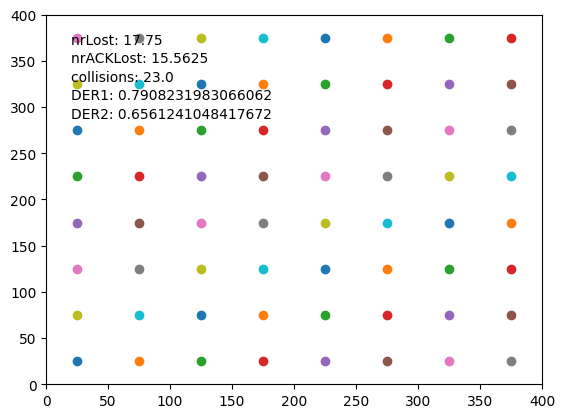

In [202]:
#change the locations of base station from [0,0] to [300,300]
import matplotlib.pyplot as plt
nrNodes = 64 # need to be int^2
datasize = 64
fieldlength = 400 # evenly distributed

bsxlist = list(range(0,400,100))
bsylist = list(range(0,400,100))
full_collision = 0
randomseed = 100
Rnd = random.seed(randomseed)

#结果展示
nrLostlist = []
nrACKLostlist = []
collisionslist = []
DER1list = []
DER2list = []

for bsx in bsxlist:
    for bsy in bsylist:
        maxBSReceives = 8
        
        Ptx = 9.75
        gamma = 2.08
        d0 = 40.0
        var = 2.0
        Lpld0 = 127.41
        GL = 0
        minsensi = np.amin(sensi[:,[125,250,500].index(Bandwidth) + 1])
        Lpl = Ptx - minsensi
        #todo: check this
        maxDist = d0*(10**((Lpl-Lpld0)/(10.0*gamma)))
        print("maxDist:", maxDist)
        
        nodes = []
        dummynodes = []
        nodeder1 = [0 for i in range(0,nrNodes)]
        nodeder2 = [0 for i in range(0,nrNodes)]
        tempdists = [0 for i in range(0,nrNodes)]
        packetsAtBS = []
        SFdistribution = [0 for x in range(0,6)]
        BWdistribution = [0 for x in range(0,3)]
        CRdistribution = [0 for x in range(0,4)]
        TXdistribution = [0 for x in range(0,13)]
        Slotsperframe  = [0 for x in range(0,6)]
        Slotlengths = [0 for x in range(0,6)]
        Framelengths = [0 for x in range(0,6)]
        Collmap = [[0 for i in range(0,6)] for j in range(0,6)]
        
        env = simpy.Environment()
        bsId = 1
        nrCollisions = 0
        nrReceived = 0
        nrProcessed = 0
        nrLost = 0
        nrLostError = 0
        nrNoACK = 0
        nrACKLost = 0
        run1(nrNodes,datasize,bsx,bsy,full_collision,randomseed)

def plot_nodes(nr_nodes, field_length, nrLost, nrACKLost, collisions,DER1,DER2):
    # Create a figure and a subplot
    fig, ax = plt.subplots()

    # Calculate and plot the position of each node
    for nodeid in range(nr_nodes):
        x, y = calculate_node_position(nodeid, nr_nodes, field_length)
        ax.scatter(x, y)

    # Add data to the plot
    ax.text(0.05 * field_length, 0.95 * field_length, f'nrLost: {nrLost}', verticalalignment='top')
    ax.text(0.05 * field_length, 0.90 * field_length, f'nrACKLost: {nrACKLost}', verticalalignment='top')
    ax.text(0.05 * field_length, 0.85 * field_length, f'collisions: {collisions}', verticalalignment='top')
    ax.text(0.05 * field_length, 0.80 * field_length, f'DER1: {DER1}', verticalalignment='top')
    ax.text(0.05 * field_length, 0.75 * field_length, f'DER2: {DER2}', verticalalignment='top')
    

    # Set the limits of the plot to the field size
    ax.set_xlim(0, field_length)
    ax.set_ylim(0, field_length)

    # Show the plot
    plt.show()
plot_nodes(nrNodes, fieldlength, np.array(nrLostlist).mean(), np.array(nrACKLostlist).mean(), np.array(collisionslist).mean(),np.array(DER1list).mean(), np.array(DER2list).mean())


In [187]:
nrLostlist

[128,
 127,
 126,
 126,
 126,
 126,
 126,
 125,
 127,
 126,
 126,
 126,
 126,
 126,
 126,
 126]

In [188]:
nrACKLostlist

[127,
 126,
 126,
 126,
 127,
 126,
 126,
 126,
 126,
 127,
 125,
 126,
 126,
 126,
 125,
 126]

In [203]:
collisionslist

[16, 16, 16, 20, 16, 22, 28, 26, 26, 28, 30, 30, 14, 24, 26, 30]

In [190]:
DER1list

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [191]:
DER2list

[0.0078125,
 0.015625,
 0.015625,
 0.015625,
 0.0078125,
 0.015625,
 0.015625,
 0.015625,
 0.015625,
 0.0078125,
 0.015748031496062992,
 0.007874015748031496,
 0.015625,
 0.015625,
 0.015748031496062992,
 0.007874015748031496]